<a href="https://colab.research.google.com/github/malinphy/hate_speech/blob/main/hate_speech_malp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import seaborn as sns

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
# from tensorflow.keras.preprocessing.layers Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score



In [2]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'

df = pd.read_csv(url)

 

In [3]:
df.head(2)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...


In [4]:
df['tweet'][4]

'!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;'

plt.hist(df['hate_speech'])

plt.hist(df['count'])

plt.hist(df['offensive_language'])

In [5]:
tweets_mali = df['tweet'].copy()
tweets = df.tweet

In [6]:
def word_counter(x):
    
    splitter = []
    for i in x:
        var1 = i.split()
        for j in var1:
            splitter.append(j)
            
    word_number_count = Counter(splitter).most_common()
    
    words = []
    words_number = []
    
    for i in word_number_count:
        words.append(i[0])
        words_number.append(i[1])
    
    
    words = words[0:50]
    words_number = words_number[0:50]
    return words,words_number

<function matplotlib.pyplot.show>

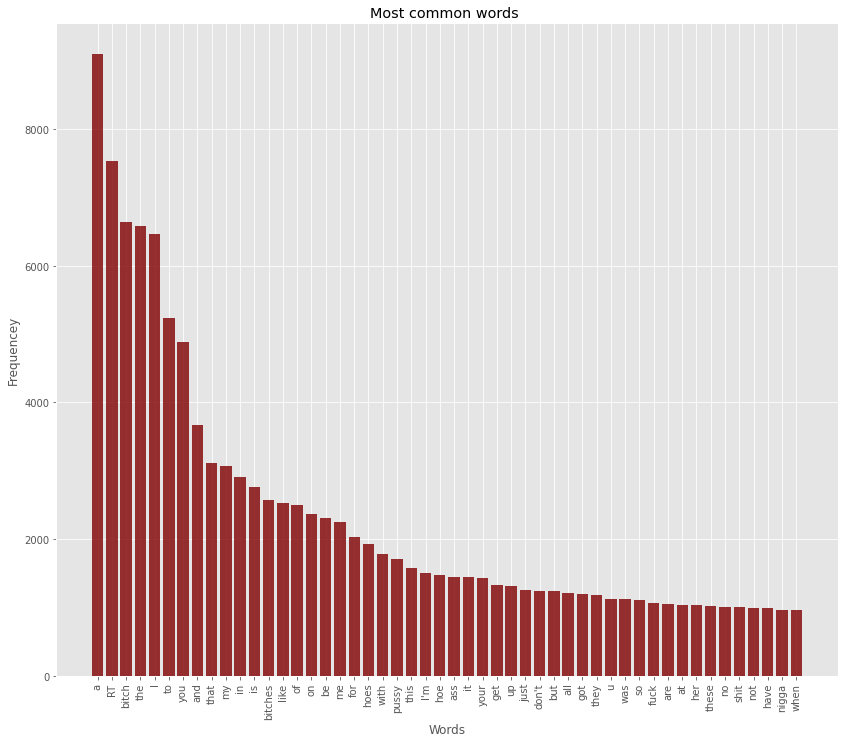

In [7]:
X,y = word_counter(tweets)
plt.style.use('ggplot')
fig = plt.figure(figsize=(14,12))

plt.bar(X,y, 
        color='maroon',
        alpha = 0.8,
        # width = 1
        )

plt.xticks(rotation=90)

plt.title("Most common words ")
plt.xlabel("Words")
plt.ylabel('Frequencey')
plt.show

In [8]:
numberOfWords = [] 

for i in range(len(tweets)):
    x = len(tweets_mali[i].split())
    numberOfWords.append(x)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sample length distribution')

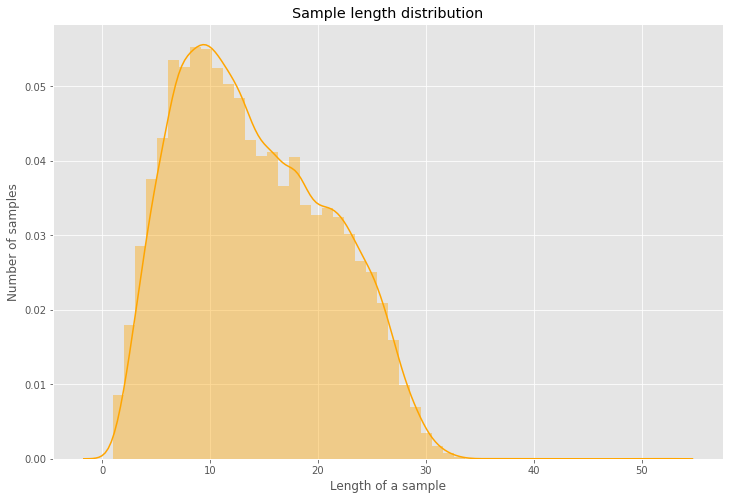

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(numberOfWords, 50  , color="orange")
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
#plt.xlim([-100,6000])

In [10]:
def tweets_cleaner (tweets_mali) :
  for i in range(len(tweets)):
      tweets_mali[i] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweets_mali[i]) # regex command to strip url links
      tweets_mali[i] = re.sub('\s+', ' ',tweets_mali[i]) # regex command to rearrange space pattern
      tweets_mali[i] = re.sub('@[\w\-]+','',tweets_mali[i]) # regex command to strip the mentions 
    
  return (tweets_mali)
    
    
def tweets_cleaner2(tweets_mali):

  RT_pattern = []
    
  for i in range(len(tweets)):
      x = re.findall(":",tweets_mali[i])
      if x == [':']:
          RT_pattern.append(i)
    
  for i in (RT_pattern):
      # regex command to strip the RT!! pattern
      tweets_mali[i] = re.split(":",tweets_mali[i])[1]
    
  for i in range (len(tweets)):
      tweets_mali[i] = re.sub("!|@|[.]|:|,|[0-9]|#|&|;|[|]|[\"]", "",tweets_mali[i])
      tweets_mali[i] = tweets_mali[i].lower()
      #tweets_mali[i] = re.sub("[0-9],",tweets_mali[i]")

  return (tweets_mali)

In [11]:
clean_tweets  = tweets_cleaner(tweets_mali)
clean_tweets_final  = tweets_cleaner2(clean_tweets) 

In [12]:
tweets_mali

0         as a woman you shouldn't complain about clean...
1         boy dats coldtyga dwn bad for cuffin dat hoe ...
2         you ever fuck a bitch and she start to cry? y...
3                                   she look like a tranny
4         the shit you hear about me might be true or i...
                               ...                        
24778       right his tl is trash  now mine? bible scri...
24779    you've gone and broke the wrong heart baby and...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled  ntac eileen dahlia - beautiful colo...
Name: tweet, Length: 24783, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

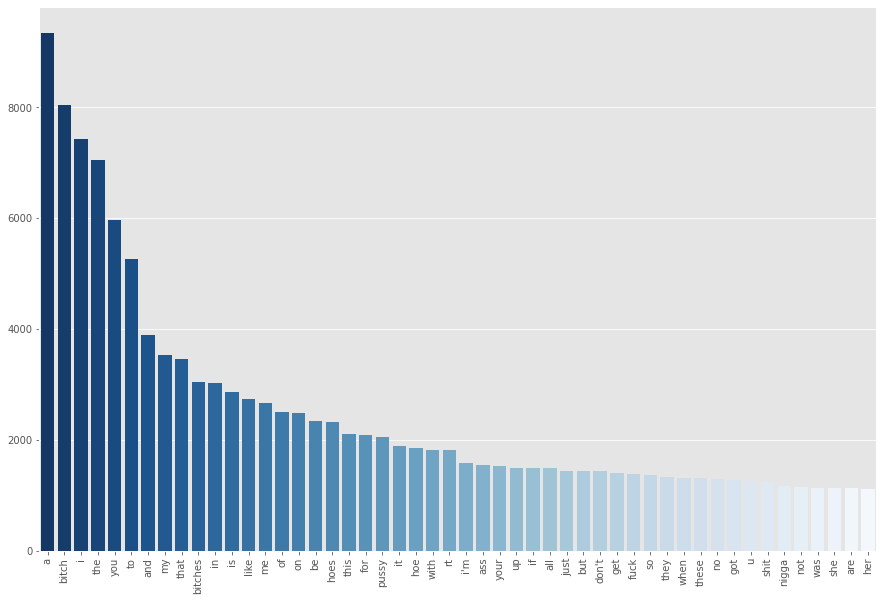

In [13]:
X_clean,y_clean = word_counter(clean_tweets_final)

plt.figure(figsize=(15,10))
sns.barplot(X_clean,y_clean, palette="Blues_r")
plt.xticks(rotation=90)
plt.show

In [14]:
df['class'].unique()

array([2, 1, 0])

In [15]:
LB= LabelBinarizer()
y= LB.fit_transform(df['class'])
np.unique(y)

array([0, 1])

In [16]:
tf_tokenizer = Tokenizer()
tokens = tf_tokenizer.fit_on_texts(clean_tweets_final)
max_length = len(tf_tokenizer.word_index)

total_seq = tf_tokenizer.texts_to_sequences(clean_tweets_final)

len_of_seq = []


[len_of_seq.append(len(i)) for i in total_seq]
max_length

longest_tweet = np.max(len_of_seq)
longest_tweet

33

In [17]:
padded_seq = pad_sequences(total_seq, maxlen = longest_tweet+1, padding= 'post')

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                                                    padded_seq, 
                                                    y, 
                                                    train_size = 0.8,
                                                    random_state= 42
                                                    )

y_train_multi, y_test_multi = train_test_split(df['class'], train_size = 0.8, random_state=42)

In [19]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((19826, 34), (4957, 34), (19826, 3), (4957, 3))

In [20]:
tf_model = keras.Sequential()
tf_model.add(layers.Embedding(25000,300, input_length = longest_tweet+1) ) # belki +1  eklerim
tf_model.add(MaxPooling1D(pool_size =2 ))
tf_model.add(layers.Flatten())
tf_model.add(layers.Dense(20,activation = 'relu'))
tf_model.add(layers.Dense(3, activation = 'softmax'))

In [21]:
tf_model.compile(
                  loss= 'categorical_crossentropy',
                  optimizer = 'adam',
                  #optimizer = 'adam(lr = 0.001)',
                  metrics = ['accuracy']
)

In [22]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 300)           7500000   
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 17, 300)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5100)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                102020    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 7,602,083
Trainable params: 7,602,083
Non-trainable params: 0
_________________________________________________________________


In [23]:
tf_model_history = tf_model.fit(x_train,y_train, epochs=10)

Epoch 1/10
620/620 [==============================] - 44s 71ms/step - loss: 0.4607 - accuracy: 0.8279
Epoch 2/10
620/620 [==============================] - 43s 69ms/step - loss: 0.2344 - accuracy: 0.9161
Epoch 3/10
620/620 [==============================] - 43s 69ms/step - loss: 0.1056 - accuracy: 0.9629
Epoch 4/10
620/620 [==============================] - 43s 70ms/step - loss: 0.0449 - accuracy: 0.9852
Epoch 5/10
620/620 [==============================] - 44s 71ms/step - loss: 0.0247 - accuracy: 0.9926
Epoch 6/10
620/620 [==============================] - 43s 70ms/step - loss: 0.0199 - accuracy: 0.9938
Epoch 7/10
620/620 [==============================] - 43s 70ms/step - loss: 0.0170 - accuracy: 0.9944
Epoch 8/10
620/620 [==============================] - 43s 70ms/step - loss: 0.0147 - accuracy: 0.9954
Epoch 9/10
620/620 [==============================] - 44s 70ms/step - loss: 0.0138 - accuracy: 0.9945
Epoch 10/10
620/620 [==============================] - 43s 70ms/step - loss: 0.013

(0.0, 20.0)

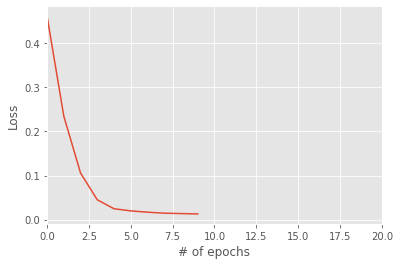

In [24]:
plt.plot(tf_model_history.history['loss'])
plt.xlabel('# of epochs')
plt.ylabel('Loss')
# plt.title('Sample length distribution')
plt.xlim([0,20])

(0.0, 30.0)

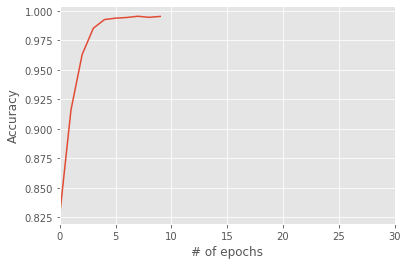

In [25]:
plt.plot(tf_model_history.history['accuracy'])
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.xlim([0,30])

In [26]:

res = tf_model.predict(x_test)

In [41]:
def decoder (x):
  decoded_res=[]
  for i in range(len(res)):
    var.append(np.argmax(res[i]))

    return decoded_res


In [45]:
len(res), len(y_test)

(4957, 4957)

In [46]:
y_pred =[]
y_test_2 = []
for i in range(len(res)):
    y_pred.append(np.argmax(res[i]))
    y_test_2.append(np.argmax(y_test[i]))

In [53]:
from mlxtend.evaluate import confusion_matrix
y_target =    [1, 1, 1, 0, 0, 2, 0, 3]
y_predicted = [1, 0, 1, 0, 0, 2, 1, 3]

cm = confusion_matrix(y_target=y_test_2, 
                      y_predicted=y_pred, 
                      binary=False)
cm

array([[  65,  199,   26],
       [  98, 3575,  159],
       [  12,  197,  626]])

Text(0.5, 24.0, '\\textbf{Predicted categories}')

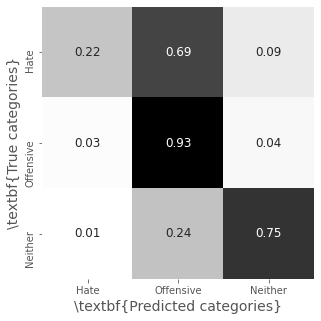

In [58]:
confusion_matrix = cm
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'\textbf{True categories}',fontsize=14)
plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)